# Project Members

    Ricardo Martinez
    Christine Robinson
    Marc Gomez Freixa
    Miguel Ibarra
    Md Mabeshareul "Prottoy" Islam
    Mahmuda Sultana

    
# Imports

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy import integrate
import matplotlib.pyplot as plt

from numpy import array


import os
import sys
import time

import subprocess
import itertools as itt
from multiprocessing import Pool

%config InlineBackend.figure_format = 'svg'
%config InteractiveShell.ast_node_interactivity = 'all'

# MapK Model Variant_26 

   https://www.ebi.ac.uk/biomodels-main/BIOMD0000000026
   
   
    Each Xi represents a reactant's concentration
   
    # Main Actor
    x1 = M   = un-phosphorylated Kinase
    x2 = Mp  = mono-phosphorylated Kinase
    x3 = Mpp = di-phosphorylated Kinase
    
    x4 = MAPK = Kinase-Kinase
    
    x5 = MPK  = Phosphatase
    
    # Concentration at specific events of intermediates complexes
    
    # Phosphorylating/Dephosphorylating
    x6 = M_MAPK  = x1*MAPK = 1st phosphorylation 
    x7 = Mp_MAPK = x2*MAPK = 2nd phosphorylation
    
    x8 = Mpp_MPK = x3*MPK  = 1st de-phosphorylation
    x9 = Mp_MPK  = x2*MPK  = 2nd de-phosphorylation
    
    # Assocication/Dissociation
    x10 = Mp_MPK* = x2*MPK  = 2nd order associatoin/dissociation
    x11 = M_MPK   = x1*MPK  = 1st order association/dissociation
    


#### Using the following ODE model:

<img src=./img/model.png>

#### And the following parameters:
    
<img src=./img/parameters.png>



## Task A.1.1

#### Perform numerical simulations such that the following conditions are observed:
    
<img src=./img/conditions.png>

#### This reduces down to the following system of equations in matrix form:

<img src=./img/system.png>


## [SAGE](https://cocalc.com/app)|Preliminary Work
    
    The SAGE platform  is used to find:
    
        X | A*X = Y,
        
        Where Y = [[100], [50], [200]] 
        # a column vector
        
    as well as the kernel of A (X0)  (X_naught)
        X0 | A*X0 = 0

```python


# coefficients matrix (A) of the conditions to be satisfied
A = matrix(QQ, [[0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
                [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
                [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]])

n = A.ncols() # n=11

# conditional bounds vector (Y)
Y = vector(QQ, [100, 50, 200])

# solve_right() in SAGE returns the matrix
# vector (X) such that A*X = Y
X = A.solve_right(Y)


####### X0 = A.right_kernel() #############
# right_kernel in SAGE returns the matrix 
# vector (X0) such that A*X0 = 0

# 'pivot' returns X0 in reduced row echelon form

# .basis() converts X0 such that it is a basis 
X0 = A.right_kernel(basis='pivot').basis()

# The Kernel has dimensions (8x11)
# we create a random vector v of len_8
# to generate a valid solutions which 
# satisfies the conditions given by Y and
# captured by X and X0
v = vector(QQ, [0,2,3,4,5,6,7,8]) # can be initialized with any values

# converts X0 (basis) to a datatype which
# allows the operation X + v*X0
X0 = matrix(QQ, X0)

solution = X + v * X0

Y_check = sum(solution[i]*A.column(i) for i in range(n))
Y_check == Y
# True
```

<Figure size 720x504 with 0 Axes>

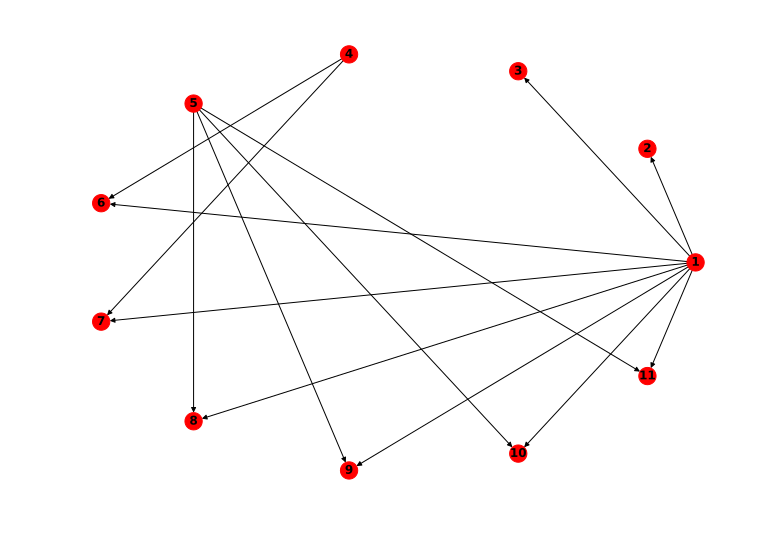

In [2]:
# NETWORK_X  library is used to visualize formed by the kernel (X0)
            
#Example
# X0 = array([[-1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],   (1, 2) (out_node, in_node)
#             [-1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],   (1, 3) 
#             [-1,  0,  0, -1,  0,  1,  0,  0,  0,  0,  0],   (1, 6) , (4, 6) 
#             [-1, ...], ...]

DG = nx.DiGraph()

# column-numbered nodes
nodes=[1,2,3,4,5,6,7,8,9,10,11]

n_labels={1:"M", 2:"Mp", 3:"Mpp", 4:"MAPK", 5:"MPK",
          6:"M-MAPK:", 7:"Mp-MAPK", 8:"Mpp-MPK", 
          9:"Mp-MPK", 10:"Mp-MPK*", 11:"M-MPK"}

edges=[(1,2),(1,3),(1,6),(4,6),(1,7),(4,7),(1,8),
       (5,8),(1,9),(5,9),(1,10),(5,10),(1,11),(5,11)]

for n in nodes:
    DG.add_node(n)
    
for e in edges:
    DG.add_edge(e[0],e[1])

plt.figure(figsize=(10,7))
g1 = nx.draw_circular(DG, with_labels=True, font_weight='bold')
plt.show()

In [3]:
#Labeled

#plt.figure(figsize=(10,7))
#g2 = nx.draw_circular(DG, with_labels=True, labels=n_labels, font_weight='bold')
#plt.show()


## MapK Model Function

In [4]:
def mapK(init_state:list, t, k:list):
    """The following function models the ODE MAPK cascade
    and is fed inot SciPy ODE int solver to obtain a 
    numerical solution. It uses a initial sate attained
    from SAGE's Kernel"""
    
    # an initial state is made by X0
    x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11 = init_state
    
    # parameters constants have been determined experimentally
    k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15,k16 = k
    
    # dx/dt equations
    dx1 = k2*x6 + k15*x11 - k1*x1*x4 - k16*x1*x5
    dx2 = k3*x6 + k5*x7 + k10*x9 + k13*x10 - x2*x5*(k11 + k12)-k4*x2*x4
    dx3 = k6*x7 + k8*x8 - k7*x3*x5
    dx4 = x6*(k2 + k3) + x7*(k5 + k6) - k1*x1*x4 - k4*x2*x4
    dx5 = k8*x8 + k10*x9 + k13*x10 + k15*x11 - x2*x5*(k11 + k12) - k7*x3*x5 - k16*x1*x5
    dx6 = k1*x1*x4 - x6*(k2 + k3)
    dx7 = k4*x2*x4 - x7*(k5 + k6)
    dx8 = k7*x3*x5 - x8*(k8 + k9)
    dx9 = k9*x8 - k10*x9 + k11*x2*x5
    dx10= k12*x2*x5 - x10*(k13 + k14)
    dx11= k14*x10 - k15*x11 + k16*x1*x5

    return [dx1,dx2,dx3,dx4,dx5,dx6,dx7,dx8,dx9,dx10,dx11]

## Helper Functions

In [5]:
def parse_bertini_main_data(fl):
    """
    :param fl: file object of the main_data output from Bertini 1.6
    :type f1: file-like object 
    :return: list of solutions
    """
    it = (line.strip() for line in fl)
    number_variables = next(it)
    solution_dimension = int(number_variables[21:])
    variables = next(it)
    rank = next(it)
    _ = next(it)
    dimension_title = next(it)
    _ = next(it)
    non_singular_title = next(it)
    
    line = next(it)
    solns = []
    while line == '---------------':
        path_number = next(it)
        component_number = next(it)
        estimated_condition_number = next(it)
       
        components = []
        for i in range(solution_dimension):
            component = next(it)

            re, im = component.split(' ')
            component = float(re) + 1j * float(im)
            components.append(component)
        solns.append(components)
        
        multiplicity = next(it)
        deflations = next(it)
        line = next(it)
        
    return solns


def triage_solns(solns, atol=1e-5):
    """Segregates the REAL solutions from 'bertini' total output """
    keep = []
    for soln in solns:
        soln = np.array(soln)
        re = np.real(soln)
        im = np.imag(soln)
        if np.allclose(np.zeros(shape=im.shape), im, atol=atol) and np.all(re >= 0):
            #print(np.zeros(shape=im.shape), im)
            keep.append(re)        
    return np.array(keep)


def triage_repeater(k_x_bound, btni_in:str, output_folder:str, subfolder_format:str):
    """Function designed to call the triage solutions multiple times"""
    
    # ensures bertini folder path is unchanged by
    # the subsequent os.chdir calls

    main_work_dir = os.getcwd()
        
    subfolder=os.path.join(output_folder, subfolder_format.format(k_x_bound))
    
    if not os.path.exists(subfolder):
        os.mkdir(subfolder)
        
    os.chdir(subfolder)
    with open(os.path.join(subfolder, 'input'), 'w') as file:
        payload = btni_in.format(k_x_bound)
        file.write(payload)
        
    ###############################
    ## location of 'bertini' app ##
    ###############################
    # structured as follows only for readability #
    
    # Alternatively (and recommended): if installed properly a linux 
    # system ,the following call should run bertini:
    
        # subprocess.call(['bertini'])
    
    bertini_rel_path = "BertiniLinux64_v1.6/bertini"
    BERTINI=os.path.join(main_work_dir, bertini_rel_path)
    subprocess.run(BERTINI)
    ##### ##### ######## ####### ##
    
    with open(os.path.join(subfolder, 'main_data')) as file:
        data = parse_bertini_main_data(file)
    
    triaged = triage_solns(data)
    
    return triaged


def k_x_upper_lower_range(k_x_lower, k_x_upper, vals_dict, btni_in, k_x_str, output_folder, subfolder_fmt):
    
    # main working directory
    main_work_dir = os.getcwd()
    
    # use the function namespace to prevent shadowing
    k_x_lower, k_x_upper, values_dict = k_x_lower, k_x_upper, vals_dict
    
    output = []
    i = 0
    while k_x_upper - k_x_lower > 1:
        s = (k_x_lower + k_x_upper) / 2
        
        subfolder = os.path.join(output_folder, subfolder_fmt.format(i))
        if not os.path.exists(subfolder):
            os.mkdir(subfolder)
            
        os.chdir(subfolder)
        with open(os.path.join(subfolder, 'input'), 'w') as file:
            file.write(bertini_input.format(k_x_upper))
            
        ###############################
        ## location of 'bertini' app ##
        ###############################
        # structured as follows only for readability #

        # Alternatively (recommended) and if installed properly a linux 
        # system should be able to call it using the command:
        # subprocess.call(['bertini'])
        
        #BERT="""/home/rdmtinez/Documents/B-IT MS Program/Semester 3/Block Courses/"""
        #TINI= """Weber Modeling & Simulation/BertiniLinux64_v1.6/bertini"""
        #subprocess.run(BERT+TINI)
        
        bertini_relative_path = "BertiniLinux64_v1.6/bertini"
        BERTINI=os.path.join(main_work_dir, bertini_relative_path)
        subprocess.run(BERTINI)
        
        ###############################
        
        
        main_data_path = os.path.join(subfolder, 'main_data')
        with open(main_data_path) as file:
            data = parse_bertini_main_data(file)
        
        n = len(triage_solns(data))
        
        values_dict[s] = n
        
        output.append([k_x_lower, k_x_upper, s, n])

        if n == 1:
            print('[{:.4f}, {:.4f}] {} = {:.4f} got {}. Bisect ↑'.format(k_x_lower, k_x_upper, k_x_str, s, n))
            k_x_lower = s
        
        else: # n==3
            print('[{:.4f}, {:.4f}] {} = {:.4f} got {}. Bisect ↓'.format(k_x_lower, k_x_upper, k_x_str, s, n))
            k_x_upper = s
        
        print("Completed Search in Range [{}, {}]".format(k_x_lower, k_x_upper))        
        
        i += 1
        
    return output, values_dict

def quickplot(df):
    
    """"visualization of results:
    
    # Main Actors 
    
    # Substrates
    x1 = M   = un-phosphorylated Kinase
    x2 = Mp  = mono-phosphorylated Kinase
    x3 = Mpp = di-phosphorylated Kinase
    
    # Enzymes
    x4 = MAPK = Kinase-Kinase
    x5 = MPK  = Phosphatase
    
    # Actor concentration @ EVENTS
    
    # Phosphorylating/Dephosphorylating events
    x6 = M_MAPK  = x1*MAPK = 1st phosphorylation 
    x7 = Mp_MAPK = x2*MAPK = 2nd phosphorylation
    
    x8 = Mpp_MPK = x3*MPK  = 1st de-phosphorylation
    x9 = Mp_MPK  = x2*MPK  = 2nd de-phosphorylation
    
    # Assocication/Dissociation events
    x10 = Mp_MPK* = x2*MPK  = 2nd order associatoin/dissociation
    x11 = M_MPK   = x1*MPK  = 1st order association/dissociation
    
    """
    
    
    plt.figure(figsize=(11, 7))
    plt.plot(t, df[["x1","x2","x3","x4","x5"]].sum(axis=1));
    plt.plot(t, df[["x5","x8","x9","x10","x11"]].sum(axis=1));
    plt.plot(t, df[["x4","x6","x7"]].sum(axis=1))
    plt.plot(t, df[["x1","x2","x3","x6","x7","x8","x9","x10","x11"]].sum(axis=1))
    plt.plot(t, df.sum(axis=1))
    
    plt.title("Concentration over Time")
    plt.xlabel("Time")
    plt.ylabel("Sum of Concentrations")
    
    plt.legend(['Main Actors: $x_1 + x_2 +x_3 +x_4 +x_5$', 
                'Phosphatases: $x_5 +x_8 +x_9 +x_{10} +x_{11}$',
                'Kinases: $x_4 + x_6 + x_7$',
                'Kinases & Intermediates: $x_1 +x_2 +x_3 +x_6 +x_7 +x_8 +x_9 +x_{10} +x_{11}$',
                'Sum Over All $x_i$'])
    
    plt.show()

### Numerical Simulation Execution

In [6]:
# conditional bounds
a,b,c = 100, 50, 200

# matrix of coefficients (A)
A = array([[0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1],
           [0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
           [1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]])


# conditional bound constants
Y = array([a,b,c])

# X | AX = Y
X = array([c, 0, 0, b, a, 0, 0, 0, 0, 0, 0])


# Kernel(A) --- X0 | A*X0 = 0
# This allows the construction of a valid starting
# vector which can then be used to find the solution
# to the system of ordinary differential equations
X0 = array([[-1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
            [-1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0],
            [-1,  0,  0, -1,  0,  1,  0,  0,  0,  0,  0],
            [-1,  0,  0, -1,  0,  0,  1,  0,  0,  0,  0],
            [-1,  0,  0,  0, -1,  0,  0,  1,  0,  0,  0],
            [-1,  0,  0,  0, -1,  0,  0,  0,  1,  0,  0],
            [-1,  0,  0,  0, -1,  0,  0,  0,  0,  1,  0],
            [-1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  1]])



In [7]:
# randomly initialized vector
v = np.random.uniform(size=8)
v

array([0.30479477, 0.27762758, 0.70857471, 0.41971914, 0.27530817,
       0.4470123 , 0.4763047 , 0.82803283])

In [8]:
# "init" is a valid initial_state. It is in the NullSpace of A
# AND is within the solution space of A bounded by
# the paremeters Y

init = X + v @ X0

init

# ensures init is a valid solution
assert np.allclose(Y, sum(init[i] * A[:,i] for i in range(11)))

array([196.26262579,   0.30479477,   0.27762758,  48.87170615,
        97.97334199,   0.70857471,   0.41971914,   0.27530817,
         0.4470123 ,   0.4763047 ,   0.82803283])

In [9]:
# 1000 time-points between 1 - 100
t = np.linspace(1,100,1000)

# parameter constants are given 
k = [0.02, 1, 0.01, 0.032, 1, 15, 0.045, 1, 0.092, 1, 0.01, 0.01, 1, 0.5, 0.086, 0.0011]

# numerical solution using SciPy
solution = integrate.odeint(mapK, init, t, args=(k,))

In [10]:
# dataframe of "solution"
df = pd.DataFrame(solution, columns=["x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","x11"])
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,196.262626,0.304795,0.277628,48.871706,97.973342,0.708575,0.419719,0.275308,0.447012,0.476305,0.828033
1,179.826220,0.323042,0.465562,34.721812,95.893012,15.172378,0.105810,0.417018,0.436606,0.438620,2.814744
2,169.573601,0.339700,0.418728,26.329923,94.002106,23.632985,0.037092,0.553487,0.429324,0.406987,4.608096
3,162.791442,0.359268,0.357886,21.229140,92.279456,28.750441,0.020419,0.648905,0.424770,0.380738,6.266131
4,158.064484,0.379913,0.314958,18.075613,90.683741,31.908885,0.015501,0.711662,0.422526,0.359290,7.822781



#### Do the trajectories converge to the same value for all those initial values? Do the values of the following sums stay constant?

<img src="./img/task1_1_traj.png">

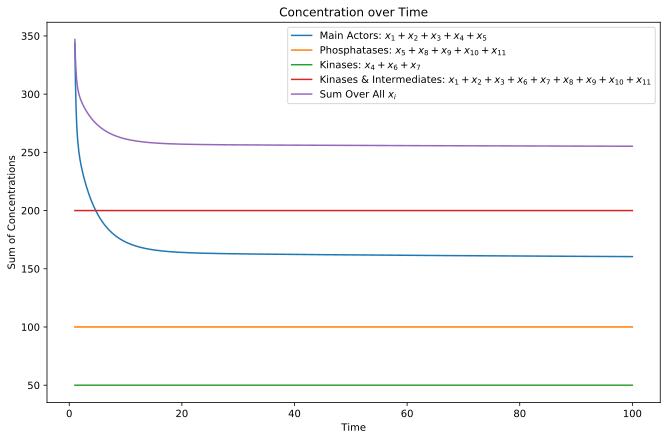

In [11]:
quickplot(df)

## Task A.1.2

    Perform similar computations as in Task A.1.1, but now the initial values should obey:
    
<img src=./img/conditions2.png>


In [12]:
# initialized with new bounds
a, b, c = 100, 50, 500
X = array([c, 0, 0, b, a, 0, 0, 0, 0, 0, 0])
v = np.random.uniform(size=8)

In [13]:
init = X + v @ X0
t = np.linspace(1,100,1000)
k = [0.02, 1, 0.01, 0.032, 1, 15, 0.045, 1, 0.092, 1, 0.01, 0.01, 1, 0.5, 0.086, 0.0011]

In [14]:
solution = integrate.odeint(mapK, init, t, args=(k,))

In [15]:
df = pd.DataFrame(solution, columns=["x1","x2","x3","x4","x5","x6","x7","x8","x9","x10","x11"])
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,496.109579,0.770482,0.942057,48.926024,98.896094,0.906841,0.167135,0.094285,0.222032,0.752324,0.035264
1,462.474834,0.685446,0.765362,20.384474,93.541169,29.548826,0.066700,0.431671,0.268603,0.711917,5.046641
2,448.244475,0.668497,0.607635,10.681572,88.839035,39.290290,0.028138,0.650051,0.305975,0.670105,9.534835
3,440.618711,0.674297,0.497055,7.207900,84.582163,42.777551,0.014549,0.784026,0.338186,0.631018,13.664608
4,435.501087,0.688812,0.427288,5.948464,80.668722,44.041693,0.009843,0.863764,0.366530,0.595643,17.505342


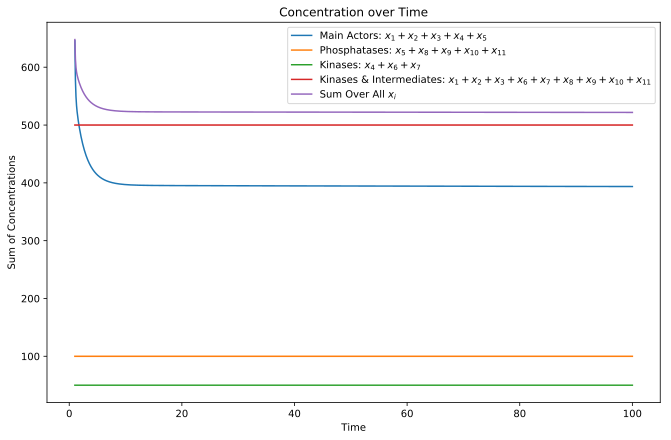

In [16]:
# plot of trajectories as defined
# in the quick_plot function
quickplot(df)

## Task A.1.3


#### Using the Bertini homotopy solver to obtain solutions:
    
* Compute solutions for varying values of \$k_{19} \in [200, 500]$
* Determine the No. of Real Solutions


### Bertini Input

In [18]:
###########################################################
## the input to the 'bertini' application                ##
## k19 --the overall concentration-- to be varied        ##
## k17 -- Phosphatase + Kinase_Phosphatase Intermediates ##
## k18 -- Kinase + Kinase_Kinase Intermediates           ##
###########################################################

bertini_input = """
CONFIG
TRACKTYPE: 1;
INPUT
function y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13, y14;
variable_group x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11;
constant k1, k2, k3, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15, k16, k17, k18, k19;

k1 = 0.02;
k2 = 1;
k3 = 0.01;
k4 = 0.032;
k5 = 1;
k6 = 15;
k7 = 0.045;
k8 = 1;
k9 = 0.092;
k10 = 1;
k11 = 0.01;
k12 = 0.01;
k13 = 1;
k14 = 0.5;
k15 = 0.086;
k16 = 0.0011;

k17 = 100;
k18 = 50;
k19 = {};

y1 = k2 * x6 + k15 * x11 - k1 * x1 * x4 - k16 * x1 * x5;
y2 = k3 * x6 + k5 * x7 + k10 * x9 + k13 * x10 - x2 * x5 * (k11 + k12) - k4 * x2 * x4;
y3 = k6 * x7 + k8 * x8 - k7 * x3 * x5;
y4 = x6 * (k2 + k3) + x7 * (k5 + k6) - k1 * x1 * x4 - k4 * x2 * x4;
y5 = k8 * x8 + k10 * x9 + k13 * x10 + k15 * x11 - x2 * x5 * (k11 + k12) - k7 * x3 * x5 - k16 * x1 * x5; 
y6 = k1 * x1 * x4 - x6 * (k2 + k3);
y7 = k4 * x2 * x4 - x7 * (k5 + k6);
y8 = k7 * x3 * x5 - x8 * (k8 + k9);
y9 = k9 * x8 - k10 * x9 + k11 * x2 * x5;
y10 = k12 * x2 * x5 - x10 * (k13 + k14);
y11 = k14 * x10 - k15 * x11 + k16 * x1 * x5;

y12 = x5 - k17 + x8 + x9 + x10 + x11;
y13 = x4 - k18 + x6 + x7;
y14 = x1 - k19 + x2 + x3 + x6 + x7 + x8 + x9 + x10 + x11;

END;
"""

### Bertini Solver Execution

In [19]:
### EXECUTE THIS ONLY ONCE###
### or hardcode main_work directory

### if you experience an error,  reset notebook ###

main_dir = os.getcwd()
os.chdir(main_dir)
main_dir

'/home/rdmtinez/Documents/B-IT MS Program/Semester 3/Block Courses/Weber Modeling & Simulation'

In [20]:
#######################################
## Bertini runs output Folder        ## 
## ENSURE RELEVANT WORKING DIRECTORY ##
#######################################


out_folder = os.getcwd()+'/mapk_26/'

if not os.path.exists(out_folder):
    os.mkdir(out_folder)


subfolder_fmt = "input{:04}"

In [21]:
#################
##### Bounds #### Bertini will output olutions within these bounds
#################
k_19_lower = 200
k_19_upper = 500

# lower-bound solution
k_19_lower_soln = triage_repeater(k_19_lower, bertini_input, out_folder, subfolder_fmt)
os.chdir(main_dir)

# upper-bound solution
k_19_upper_soln = triage_repeater(k_19_upper, bertini_input, out_folder, subfolder_fmt)
os.chdir(main_dir)


In [ ]:
k_19_lower_soln
print("No. Real Solutions:", len(k_19_lower_soln))
print()

k_19_upper_soln
print("No. Real Solutions:", len(k_19_upper_soln))

## Task A.1.4
#### Performing the Computations from Task A.1.3:
* Determine approximately (by bisecting values up to one digit of accuracy) the value of $k_{19}$ at which the system changes its behavior (from a single fixed point to 3 fixed points).

#### Execution

In [ ]:
#names_dict = {0: k_19_lower, 1: k_19_upper}
values_dict = {k_19_lower: len(k_19_lower_soln), k_19_upper: len(k_19_upper_soln)}

In [ ]:
##############################
##Bertini runs output Folder## 
##############################
out_folder = os.getcwd()+'/mapk_26/'
if not os.path.exists(out_folder):
    os.mkdir(out_folder)


subfolder_fmt = "input{:04}"

In [ ]:
# lower range solution
k_19_lower, k_19_upper = 200.0, 500.0

k_19_range, values_dict  = k_x_upper_lower_range(k_19_lower, k_19_upper, 
                                                values_dict, bertini_input,
                                                "k_19", out_folder, subfolder_fmt)
os.chdir(main_dir)

In [ ]:
# upper range solution
k_19_lower, k_19_upper = 350.0, 500.0

k_19_range, values_dict  = k_x_upper_lower_range(k_19_lower, k_19_upper, 
                                                values_dict, bertini_input,
                                                "k_19", out_folder, subfolder_fmt)
os.chdir(main_dir)


In [ ]:
# output of data
print("k_19_range: ", k_19_range)
print()
print("values_dictionary:\n", values_dict)

In [ ]:
def quickplot2(values_dict):
    x = sorted(values_dict)
    y = [values_dict[key] for key in x]
    
    plt.figure(figsize=(11,7))
    plt.plot(x, y)
    plt.ylim(0, 4)
    plt.ylabel('Number of Fixed Points')
    plt.xlabel('k19')
    plt.show()

In [ ]:
quickplot2(values_dict)

In [ ]:
print("The System Changes behavior when k19 >= 350")

## Task A.1.5
    
    # TODO